In [1]:
import numpy
from matplotlib import pyplot as plt
from scipy import io
from scipy.special import expit as sigmoid
%matplotlib inline

First, load the data (same as from exercise 3) and make a function to visualize it:

In [2]:
# loadedData = io.loadmat("ex4/ex4data1.mat")
loadedData = io.loadmat("../machine-learning-ex3/ex3/ex3data1.mat")
print loadedData.keys()
# Load into temporary spots
x_temp = loadedData['X']
y_temp = loadedData['y']

['y', 'X', '__version__', '__header__', '__globals__']


Let's add an additional x0 entry to each sample value to make sure we can properly include the bias term

In [3]:
x = numpy.insert(x_temp,0,1,axis=1)
print x.shape

(5000, 401)


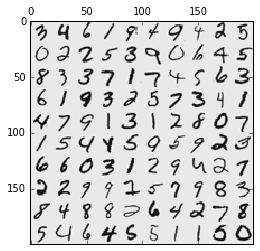

In [4]:
def getImage(index):
    image = x[index][1:]
    # This reshapes the image into a 20x20 array for displaying:
    image.shape=(20,20)
    return image

def makeLargeImage():
    # The final image is a big array of 100 images of 20x20 each.  That means it's 100*400 floats long:
    stride = 20
    master = numpy.zeros((10*stride, 10*stride))
    for i_x in xrange(10):
        for i_y in xrange(10):
            index = int(5000*numpy.random.rand())
            im = getImage(index)

            # This is probably the trickiest part: we have to insert the small image into the master image
            # But with numpy, it's not really so bad.  Check out this stack overflow reference:
            # http://stackoverflow.com/questions/7115437/how-to-embed-a-small-numpy-array-into-a-predefined-block-of-a-large-numpy-arra
            master[i_x*stride:i_x*stride+stride, i_y*stride:i_y*stride+stride] = im.T
    return master


master = makeLargeImage()
plt.matshow(master,cmap=plt.cm.gray_r)

Load in the weights for the pretrained network:

In [5]:
loadedWeights = io.loadmat("ex4/ex4weights.mat")
theta1 = loadedWeights['Theta1']
theta2 = loadedWeights['Theta2']
print theta1.shape
print theta2.shape

(25, 401)
(10, 26)


Repackage the y variable to allow each entry to be a 10 dimensional array

In [6]:
y = numpy.zeros((len(y_temp),10))


for label, i  in zip(y_temp, xrange(len(y_temp))):
#     if label < 10:
#         y[i][label] = 1
#     else:
#         y[i][0] = 1
    y[i][label-1] = 1

print y.shape

(5000, 10)


Define the cost function and some other working functions.  I'll make two copies, to make it easy to check things.  The first copy of each function works on single iterations, and the second copy works on a whole data set in a vectorized way.

In [7]:
def z(a,_theta):
    # z should be the product of theta and a, so make sure the dimensions work out.
    # Doing this with matrix multiplication, so each while _theta is probably a matrix already, a is likely not.
    if (a.ndim == 1):
        a = a.reshape((len(a),1))
    _vals = numpy.dot(_theta, a)
    return _vals.flatten()

# Also make a vectorized versin that will work on the input "a":
def z_vec(a, _theta):
    # This time, a is a vector of vectors (you know ... a matrix)
    # It can still work, if we apply the dot product properly
    # This means using tensor dot
    return numpy.tensordot(_theta, a, axes=[1,1]).T


In [8]:
#Let's make sure it's working, by compaing the normal and the vectorized answers:
print sigmoid(z(x[0],theta1))
print z(x[0], theta1 ) - z_vec(x[0:1], theta1)
print z(x[150], theta1) - z_vec(x[100:200], theta1)[50]


[ 0.05036187  0.07939572  0.99300197  0.51872368  0.70524833  0.99649533
  0.01073784  0.00163257  0.99649905  0.02040086  0.07178715  0.02166121
  0.04619385  0.05028779  0.00421782  0.88700616  0.99200482  0.09693938
  0.84785892  0.79771612  0.02382443  0.98384703  0.97251796  0.94342162
  0.10721379]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]]
[  1.77635684e-15  -6.66133815e-16   3.10862447e-15  -3.60822483e-16
   0.00000000e+00   2.66453526e-15   1.77635684e-15   0.00000000e+00
   8.88178420e-16   1.33226763e-15   4.44089210e-16   2.22044605e-16
   0.00000000e+00  -1.33226763e-15  -4.44089210e-16  -2.49800181e-16
  -2.22044605e-16   0.00000000e+00  -2.22044605e-16   1.77635684e-15
   0.00000000e+00   1.33226763e-15   4.44089210e-16  -2.66453526e-15
  -2.22044605e-16]


It's looking like it's working.  Just for fun, let's see how much faster the vectorized version is:

In [9]:
import time

def z_loop():
    _this_y = numpy.zeros((len(x), 25))
    for i in xrange(len(x)):
        _this_y[i] = z(x[i], theta1)

now = time.time()
z_loop()
finish = time.time()
        
now_vec = time.time()
z_vec(x,theta1)
finish_vec = time.time()

print "Non vectorized version: {:.3}".format(finish - now)
print "Vectorized version: {:.3}".format(finish_vec - now_vec)

Non vectorized version: 0.0994
Vectorized version: 0.0159


Clearly, that's a big difference in execution time.  That said, it's useful to have the simpler version because you have to do it right before you can do it fast.

Now write some functions to do the forward pass, in both the normal and vectorized way:

In [10]:
def forward(x, _theta1, _theta2):
    z2 = z(x, _theta1)
    a2 = sigmoid(z(x, _theta1))
    # Add the bias unit to a2:
    a2 = numpy.insert(a2,0,1)
    z3 = z(a2, _theta2)
    a3 = sigmoid(z(a2, _theta2))
    return a3

def forward_vec(x, _theta1, _theta2):
    a2 = sigmoid(z_vec(x, _theta1))
    # Add the bias unit to a2:
    a2 = numpy.insert(a2,0,1,axis=1)
    a3 = sigmoid(z_vec(a2, _theta2))
    return a3


In [11]:
i = int(5000*numpy.random.rand())
print forward_vec(x[0:1],theta1, theta2) - forward(x[0],theta1, theta2)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


Run the forward pass to see that we're getting reasonable results:

In [12]:
i = int(5000*numpy.random.rand())
print "Selected value is {}".format(numpy.argmax(forward(x[i],theta1, theta2)))
print "Correct value is {}".format(numpy.argmax(y[i]))

Selected value is 1
Correct value is 1


(Remember, here, that the pretrained weights order the numbers 1, 2, 3, 4, 5, 6, 7, 8, 9, 0) and we are zero indexing here.  So, in this case '1' as the results really indicates that the selected answer is the number 2.

And again, for fun, let's see the time difference between the vectorized and non-vectorized version

In [13]:
import time

def forward_loop():
    _this_y = numpy.zeros((len(x), 10))
    for i in xrange(len(x)):
        _this_y[i] = forward(x[i], theta1, theta2)

now = time.time()
forward_loop()
finish = time.time()
        
now_vec = time.time()
forward_vec(x,theta1, theta2)
finish_vec = time.time()

print "Non vectorized version: {:.3}".format(finish - now)
print "Vectorized version: {:.3}".format(finish_vec - now_vec)

Non vectorized version: 0.426
Vectorized version: 0.0227


Lastly, let's write a cost function.  Once more do a vectorized and non vectorized version:

In [14]:
def cost(_x, _y, _theta1, _theta2):
    _h = forward(_x, _theta1, _theta2)
    _cost = - numpy.dot(_y,numpy.log(_h))
    _cost += - numpy.dot((1-_y), numpy.log(1-_h))
    return _cost

def cost_vec(_x, _y, _theta1, _theta2):
    # This isn't too difficult using pointwise multiplication, and then sum
    # over the output to reduce the dimensions by 1
    _h = forward_vec(_x, _theta1, _theta2)
    _cost = -numpy.multiply(_y, numpy.log(_h))
    _cost += -numpy.multiply((1-_y), numpy.log(1-_h))
    return numpy.sum(_cost, axis=1)



In [15]:
# Make sure the vectorized one is outputting correctly:
_cost = cost_vec(x, y, theta1, theta2)
print cost(x[0], y[0], theta1, theta2) - _cost[0]
print cost(x[1], y[1], theta1, theta2) - _cost[1]
print cost(x[100], y[100], theta1, theta2) - _cost[100]
print cost(x[4000], y[4000], theta1, theta2) - _cost[4000]


0.0
0.0
-3.33066907388e-16
-2.49800180541e-16


That looks spot on.  Now, all that's left to do is compute the average cost:

In [16]:
cum_cost = 0.0
for i in xrange(len(y)):
    cum_cost += cost(x[i], y[i], theta1, theta2)
cum_cost *= (1./len(y))
print "Average cost is {:.4}".format(numpy.average(cum_cost))    
print "Average cost is {:.4}".format(numpy.average(_cost))

Average cost is 0.2876
Average cost is 0.2876


0.2876 is spot on where it should be, and both methods agree.

## Regularized Cost Function

Now write a regularized cost function:

In [17]:
def cost_regularized_vec(_x, _y, _theta1, _theta2, _l):
    """
    Compute the regularized cost function.  Most of the cost is identical to above, but since
    this is only meant to work on the whole sample I'm not including a non-vectorized function
    """
    m = len(_x) 
    _cost = (1.0/m) * numpy.sum(cost_vec(_x,_y, _theta1, _theta2))
    # Need to skip the bias unit in the matrices
    _sum_theta1 = (_l/(2*m)) * numpy.tensordot(_theta1[:,1:],_theta1[:,1:])
    _sum_theta2 = (_l/(2*m)) * numpy.tensordot(_theta2[:,1:],_theta2[:,1:])
    _cost += _sum_theta1 + _sum_theta2

    return _cost



In [18]:
print cost_regularized_vec(x, y, theta1, theta2, 1.0)


0.383769859091


Again, this is right as it should be.

## Sigmoid Gradient

Here, we want to write the gradient of the sigmoid function and verify it's behavior at some extreme cases to make sure it's correct

In [19]:
def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [20]:
print grad_sigmoid(-999)
print grad_sigmoid(0)
print grad_sigmoid(999)

0.0
0.25
0.0


And, verify that it correctly computes on vectors too:

In [21]:
print grad_sigmoid(numpy.asarray([-999,-100,-1,0,1,100,999]))

[  0.00000000e+00   3.72007598e-44   1.96611933e-01   2.50000000e-01
   1.96611933e-01   0.00000000e+00   0.00000000e+00]


Looks good.

## Initializing Weights

In [22]:
def rand_init(dims, eps=None):
    # Get the dims of this theta:
    dims1 = dims[0]
    dims2 = dims[1]
    if eps is None:
        eps = numpy.sqrt(6) / numpy.sqrt(dims1 + dims2)
    return numpy.random.rand(dims1, dims2)* (2*eps) - eps

In [23]:
rand_theta1 = rand_init((25,401))
rand_theta2 = rand_init((10,26))


Verify that we're actually getting a flat distribution:

(array([  990.,  1074.,  1037.,   977.,   977.,  1018.,   955.,   964.,
          999.,  1034.]),
 array([ -1.18673814e-01,  -9.49401323e-02,  -7.12064504e-02,
         -4.74727685e-02,  -2.37390867e-02,  -5.40480972e-06,
          2.37282771e-02,   4.74619589e-02,   7.11956408e-02,
          9.49293227e-02,   1.18663005e-01]),
 <a list of 10 Patch objects>)

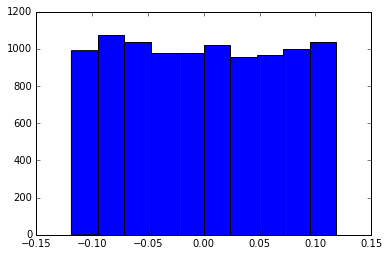

In [24]:
plt.hist(rand_theta1.flatten())

## Implement backpropogation

Even though a lot of this is implemented above, I'll redo it all here to make it clear:

In [223]:
def backprop(x, y, _theta1, _theta2):
    """
    This is not a vectorized back propogation function
    """
    z2 = z(x, _theta1)
    a2 = sigmoid(z2)
    # Add the bias unit to a2:
    a2 = numpy.insert(a2,0,1)
    z3 = z(a2, _theta2)
    a3 = sigmoid(z3)
    
    # Next compute the delta 
    d3 = a3 - y
    
    
    # Need to reshape d3 and a2 to cast them into a matrix:
    d3 = d3.reshape((len(d3), 1))
    a2 = a2.reshape((len(a2), 1))
    

    # Compute the gradient at the next step:
    _temp = numpy.dot(_theta2.T,d3).flatten()[1:]
    # (Saved the matrix multiplication but without the bias unit)
    d2 = numpy.multiply(_temp, grad_sigmoid(z2))

    
    # Accumulate the gradients:
    _delta2 = numpy.dot(d3, a2.T)
    
#     print D1.shape
    d2 = d2
    d2 = d2.reshape((len(d2),1))
    a1 = x.reshape((len(x),1))

    _delta1 = numpy.dot(d2, a1.T)
#     numpy.tensordot(numpy.dot(_theta2.T, d3), grad_sigmoid(z2), axes=1).shape
    return _delta1, _delta2
#     return D1, D2

def iteration(_x,_y,_theta1, _theta2):
    """
    Loop over the training sample and create the average update to the weights theta
    """
    D1 = numpy.zeros(_theta1.shape)    
    D2 = numpy.zeros(_theta2.shape)
    for i in xrange(len(_x)):
        d1, d2 = backprop(_x[i],_y[i],_theta1, _theta2)
        D1 += d1
        D2 += d2
    # Finish averaging the derivatives:
    D1 *= (1.0 / len(_x))
    D2 *= (1.0 / len(_x))
    return D1, D2


The octave assignments comes with an implementation of gradient checking that looks pretty useful.  We might as well implement it here to make sure things look correct.

## Gradient Checking

We know the cost function, and we can compute the gradients in the thetas as well.  If we set just one value of theta to non zero, we should get an estimate of the gradient of that theta from the cost function:

In [224]:
# Using a much smaller network for gradient checking:

def check_gradient(_epsilon, x_dim, y_dim, hidden_dim, _n_entries = 20, verbose=False):
    _rand_theta1 = rand_init((hidden_dim,x_dim))
    _null_theta1 = numpy.zeros((hidden_dim, x_dim))
    _rand_theta2 = rand_init((y_dim,hidden_dim+1))
    _null_theta2 = numpy.zeros((y_dim,hidden_dim+1))

    # Generate a sample of random data for input and output:
    fake_x = numpy.random.rand(_n_entries, x_dim)
    fake_y = numpy.random.rand(_n_entries, y_dim)

    diffs = []
    
    # Check every variable in theta1:
    for x_ind in xrange(hidden_dim):
        for y_ind in xrange(x_dim):
            # Make a copy of the zeros to make sure there is not 
            # continuous updating (remove previous iteration's changes)
            _diff_theta = numpy.copy(_null_theta1)
            _diff_theta[x_ind][y_ind] = _epsilon


            _j_plus = numpy.average(cost_vec(fake_x,fake_y,_rand_theta1 + _diff_theta,_rand_theta2))

            _j_minus = numpy.average(cost_vec(fake_x,fake_y,_rand_theta1 - _diff_theta,_rand_theta2))

            est = (_j_plus - _j_minus) / (2*_epsilon)

            D1, D2 = iteration(fake_x,fake_y,_rand_theta1, _rand_theta2)
            comp = D1[x_ind][y_ind]
            if verbose:
                print "[{}][{}]: Comp == {}, Approx == {}".format(x_ind,y_ind, comp, est)
            diffs.append(comp - est)
            
    # Check every variable in theta2:
    for x_ind in xrange(y_dim):
        for y_ind in xrange(hidden_dim):
            # Make a copy of the zeros to make sure there is not 
            # continuous updating (remove previous iteration's changes)
            _diff_theta = numpy.copy(_null_theta2)
            _diff_theta[x_ind][y_ind] = _epsilon


            _j_plus = numpy.average(cost_vec(fake_x,fake_y,_rand_theta1,_rand_theta2 + _diff_theta))

            _j_minus = numpy.average(cost_vec(fake_x,fake_y,_rand_theta1,_rand_theta2  - _diff_theta))

            est = (_j_plus - _j_minus) / (2*_epsilon)

            D1, D2 = iteration(fake_x,fake_y,_rand_theta1, _rand_theta2)
            comp = D2[x_ind][y_ind]
            if verbose:
                print "[{}][{}]: Comp == {}, Approx == {}".format(x_ind,y_ind, comp, est)
            diffs.append(comp - est)
            
    return diffs


In [226]:
_epsilon = 0.0001
print theta1.shape
print theta2.shape

diffs = check_gradient(_epsilon, x_dim=5, y_dim=5, hidden_dim = 5, _n_entries=20, verbose=True)

(25, 401)
(10, 26)
[0][0]: Comp == 0.0195089591492, Approx == 0.0195089591482
[0][1]: Comp == 0.00907309816271, Approx == 0.00907309816611
[0][2]: Comp == 0.00827746252733, Approx == 0.00827746253096
[0][3]: Comp == 0.0131808687755, Approx == 0.0131808687809
[0][4]: Comp == 0.0164507611298, Approx == 0.0164507611289
[1][0]: Comp == 0.00252000714898, Approx == 0.00252000715184
[1][1]: Comp == 0.00811901332027, Approx == 0.00811901331277
[1][2]: Comp == 0.00648752103062, Approx == 0.00648752102261
[1][3]: Comp == 0.0101752828015, Approx == 0.0101752827875
[1][4]: Comp == 0.0134698727303, Approx == 0.0134698727283
[2][0]: Comp == -0.0186721126799, Approx == -0.0186721126672
[2][1]: Comp == -0.00295810125016, Approx == -0.00295810125728
[2][2]: Comp == -0.0112306080028, Approx == -0.0112306079947
[2][3]: Comp == -0.00928060940759, Approx == -0.00928060940764
[2][4]: Comp == -0.0125363178873, Approx == -0.0125363178816
[3][0]: Comp == -0.0106175273165, Approx == -0.0106175273085
[3][1]: Com

Even with a somewhat large epsilon used, (0.01), the gradient calculation and approximation are giving very similar answers.

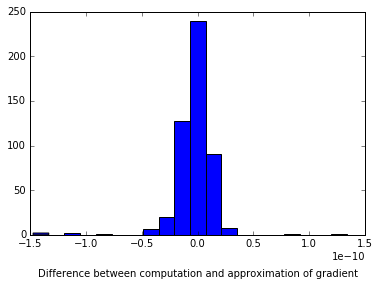

In [227]:
diffs = check_gradient(_epsilon=0.0001, x_dim=10, y_dim=10, hidden_dim = 25, _n_entries=20, verbose=False)
plt.hist(diffs,bins=20)
plt.xlabel("Difference between computation and approximation of gradient", labelpad=20)

That looks great - the different is always on the order of 1e-9 or less.  It's safe to say the gradient calculation is working.  Next, do vectorized backpropogation so it doesn't take forever to train:

In [228]:
def backprop_vec(_x,_y, _theta1, _theta2):

    """
    This IS a vectorized back propogation function, and it seems to have some bugs!
    """
    z2 = z_vec(_x, _theta1)
    a2 = sigmoid(z2)
    # Add the bias unit to a2:
    a2 = numpy.insert(a2,0,1, axis=1)
    z3 = z_vec(a2, _theta2)
    a3 = sigmoid(z3)
    
    # Next compute the delta 
    d3 = a3 - _y
    
    
    # Compute the gradient at the next step:
    _temp = numpy.average(numpy.tensordot(_theta2.T, d3, axes=[1,1]), axis=1)[1:]
    # (Saved the matrix multiplication but without the bias unit)
    d2 = numpy.multiply(_temp, grad_sigmoid(z2))
    
    
    # Reshape the axis to allow multiplication and then averaging:
    d3 = d3.reshape((len(d3), len(d3[0]), 1))
    a2 = a2.reshape((len(a2), len(a2[0]), 1))

    # numpy matmul is perfect for this, it broadcasts matrix multiplication across
    # the last two elements:
    _delta2 = numpy.matmul(d3, numpy.transpose(a2, axes=[0,2,1]))

    # Accumulate the gradients by averaging over all samples::
    _delta2 = numpy.average(_delta2, axis=0)
    
    # Get _delta1 as well:
    
    d2 = d2.reshape((len(d2), len(d2[0]), 1))
    a1 = _x.reshape((len(_x), len(_x[0]), 1))
    _delta1 = numpy.matmul(d2, numpy.transpose(a1, axes=[0,2,1]))
    _delta1 = numpy.average(_delta1, axis=0)
    
#     numpy.tensordot(numpy.dot(_theta2.T, d3), grad_sigmoid(z2), axes=1).shape
    return _delta1, _delta2
#     return D1, D2

In [249]:
_this_rand_theta1 = rand_init((25,401))
_this_rand_theta2 = rand_init((10,26))
D1_vec, D2_vec = backprop_vec(x,y, _this_rand_theta1, _this_rand_theta2)
D1, D2 = iteration(x, y, _this_rand_theta1, _this_rand_theta2)


print numpy.sum(D1 - D1_vec)
print numpy.sum(D2 - D2_vec)

0.795921908493
1.37043154602e-15


It looks like the vectorized back prop is not working (there is some roundoff error perhaps), but let's test it's speed difference again as usual:

In [250]:
import time

_this_rand_theta1 = rand_init((25,401))
_this_rand_theta2 = rand_init((10,26))

now = time.time()
D1, D2 = iteration(x, y, _this_rand_theta1, _this_rand_theta2)
finish = time.time()
        
now_vec = time.time()
D1_vec, D2_vec = backprop_vec(x, y, _this_rand_theta1, _this_rand_theta2)
finish_vec = time.time()

print "Sum of differences in D1: " + str(numpy.sum(D1 - D1_vec))
print "Sum of differences in D2: " + str(numpy.sum(D2 - D2_vec))

print "Non vectorized version: {:.3}".format(finish - now)
print "Vectorized version: {:.3}".format(finish_vec - now_vec)

Sum of differences in D1: 0.259098959731
Sum of differences in D2: 2.80331313718e-15
Non vectorized version: 0.416
Vectorized version: 0.164


It's not as dramatic a speedup as before, but it's still something.  We basically only skip the loop over all of the entries of the input vector.  (Of course, "skip" means move the loop from python to C)

In [251]:
# Implement regularized backpropogatoin:

def backprop_reg(_x,_y,_theta1, _theta2, l):
    """
    Loop over the training sample and create the average update to the weights theta
    Then, add the regulariztion term for the thetas
    """
    D1 = numpy.zeros(_theta1.shape)    
    D2 = numpy.zeros(_theta2.shape)
    for i in xrange(len(_x)):
        d1, d2 = backprop(_x[i],_y[i],_theta1, _theta2)
        D1 += d1
        D2 += d2
    # Finish averaging the derivatives:
    D1 *= (1.0 / len(_x))
    D2 *= (1.0 / len(_x))
    
    # Add the regularization for the weights:
    D1_reg = (l / len(_x)) * numpy.multiply(_theta1, _theta1)
    D2_reg = (l / len(_x)) * numpy.multiply(_theta2, _theta2)
    
    # Remove
    D1_reg[:,0] = 0.0
    D2_reg[:,0] = 0.0
    
#     D1 += 
    return D1 + D1_reg, D2 + D2_reg

In [252]:
d1, d2 = backprop_reg(x[0:10],y[0:10],rand_theta1,rand_theta2, 1.)
print d1[11][0:10]

[ -2.01886117e-01   9.85923753e-04   7.50986212e-04   4.49539525e-04
   4.26868517e-04   1.21071348e-03   4.80122616e-04   1.19418711e-05
   9.81677251e-05   6.80079443e-04]


Ok let's train the network with backprop.  Scipy comes with scipy.optimize.fmin_cg:

In [255]:
from scipy import optimize

In [270]:
# Define two functions to pass the thetas easily as a 2D list:
def backprop_unrolled(x_vals, _input_data, _answer_data, _l):
    
    # Unpack the thetas:
    _theta1 = numpy.reshape(x_vals[0:25*401], (25, 401))
    _theta2 = numpy.reshape(x_vals[25*401:], (10, 26))

    D1, D2 = backprop_reg(_input_data, _answer_data, _theta1, _theta2, _l)
    return numpy.append(D1.flatten(), D2.flatten())

def cost_unrolled(x_vals, _input_data, _answer_data, _l):
    
    # Unpack the thetas:
    _theta1 = numpy.reshape(x_vals[0:25*401], (25, 401))
    _theta2 = numpy.reshape(x_vals[25*401:], (10, 26))
    cost =  cost_regularized_vec(_input_data, _answer_data, _theta1, _theta2, _l)
    return cost
    
def train_network(_x, _y, _theta1, _theta2, _l):
    # Pack up the theta parameters into one long vector:
    x_vals = numpy.append(_theta1.flatten(), _theta2.flatten())
    res = optimize.fmin_cg(f = cost_unrolled, x0 = x_vals, fprime = backprop_unrolled,
                          args = (_x, _y, _l))
    return res

In [262]:
rand_theta1 = rand_init((25,401))
rand_theta2 = rand_init((10,26))
res = train_network(x,y, rand_theta1, rand_theta2, 1.0)


7.18127609634
3.62260164119
3.35196629377
3.2528005344
3.18598429863
3.14509290364
3.11730366974
3.01675097953
3.09517509155
2.9279062648
2.69486678668
2.65363247786
2.53547359864
2.3052360545
2.35092678797
2.18460990542
2.07435929294
1.79733433885
1.74736333741
1.748970245
1.70630839028
1.66091459432
1.54552299142
1.4782803452
1.41738509977
1.3775253666
1.36124135511
1.26395402622
1.09443460243
1.06506648451
1.06831724257
1.04328746418
1.02570120408
0.981386076919
0.966782302018
0.939906698747
0.925865123487
0.888773440774
1.02961880682
0.880508768994
0.865086342325
0.836650362589
0.821938659657
0.79153101787
0.784342701042
0.763478312084
0.790981189988
0.753882001534
0.742994009268
0.720867885954
0.714180388461
0.697918480978
0.694742855195
0.685263906149
0.702632069345
0.680909766645
0.67602800759
0.663690016379
0.731366871491
0.661824725295
0.656946900491
0.64498375493
0.710436978163
0.64341468159
0.638834175471
0.625908110366
0.659495436187
0.621477945935
0.614969833273
0.59999610

In [265]:
# Reconstruct theta1 and theta2 from res:
theta1_trained = numpy.reshape(res[0:25*401], (25, 401))
theta2_trained = numpy.reshape(res[25*401:], (10, 26))

In [271]:
# Compute the accuracy of the trained data:
y_guess = forward_vec(x,theta1_trained, theta2_trained)
print numpy.argmax(y_guess, axis=1)
print numpy.argmax(y,axis=1)
n_correct = numpy.sum(numpy.argmax(y_guess, axis=1) == numpy.argmax(y,axis=1))
n_wrong = numpy.sum(numpy.argmax(y_guess, axis=1) != numpy.argmax(y,axis=1))

[9 9 9 ..., 8 8 8]
[9 9 9 ..., 8 8 8]


In [275]:
print n_correct
print n_wrong
print "Accuracy of this network on the sample is: {:.3}%".format((100.0*n_correct) / (n_correct + n_wrong))

4759
241
Accuracy of this network on the sample is: 95.2%


## Visualize the hidden layers:

As the last step to this solution set, let's visualize the hidden layers like the problem set shows.

In [278]:
def makeHiddenLayerImage(_theta1):
    # The final image is a big array of 25 images of 20x20 each.  That means it's 25*400 floats long:
    stride = 20
    master = numpy.zeros((5*stride, 5*stride))
    for i_x in xrange(5):
        for i_y in xrange(5):
            im = _theta1[i_x*5 + i_y][1:].reshape((20,20))

            # This is probably the trickiest part: we have to insert the small image into the master image
            # But with numpy, it's not really so bad.  Check out this stack overflow reference:
            # http://stackoverflow.com/questions/7115437/how-to-embed-a-small-numpy-array-into-a-predefined-block-of-a-large-numpy-arra
            master[i_x*stride:i_x*stride+stride, i_y*stride:i_y*stride+stride] = im.T
    return master

image = makeHiddenLayerImage(theta1_trained)

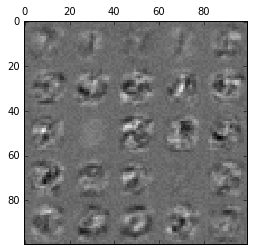

In [280]:
plt.matshow(image,cmap=plt.cm.gray_r)

Interestingly, it looks like some of the hidden layers didn't really get trained substantially.  But many of them seem to have picked upinteresting patterns of lines and circles.